In [1]:
import torch, torchvision
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import copy
import math
import random

torch.Size([1, 28, 28])
label is 1
Length of training data is 60000


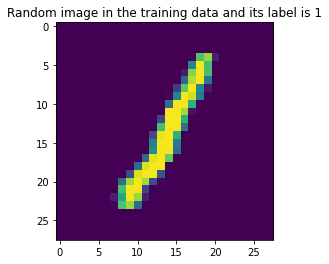

Number of examples in training set are 48000
Number of examples in validation set are 12000


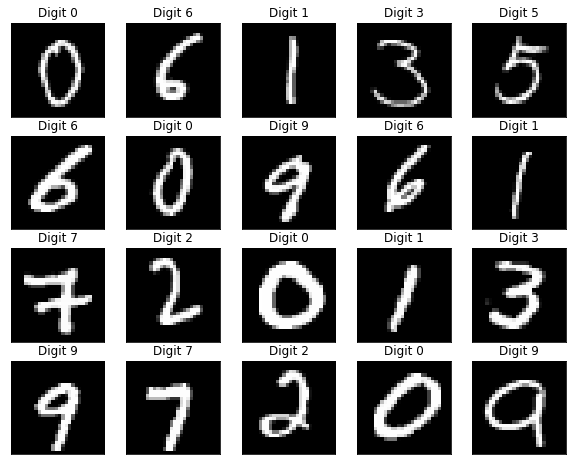

In [2]:
numb_batch = 64 # defining the number of batches

"""# Geting MNIST dataset"""

#The ToTensor() transformation is a simple one that converts input
#images into PyTorch tensors

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

#We are applying the transform on the MNIST image and loading the image tensor into train data
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True,transform=transform)

# Generate a random integer between 0 and 9 (inclusive)
random_number = random.randint(1, len(train_data))
image,label=train_data[random_number]

#checking the size of image
print(image.shape)
print(f"label is {label}")
print(f"Length of training data is {len(train_data)}")



#display the image, we have to convert it to image as it is tensor
image, label = train_data[random_number]
if image is not None:
    image = transforms.ToPILImage()(image)
    plt.title(f'Random image in the training data and its label is {label}')
    plt.imshow(image)
    plt.show()

else:
    print("Dataset is not loaded properly")

#creating the validation set
train_size=math.floor(0.8*len(train_data))
print(f"Number of examples in training set are {train_size}")
val_size=math.floor(0.2*len(train_data))
print(f"Number of examples in validation set are {val_size}")


#Randomly splitting the data into training and validation
training_data,val_data=torch.utils.data.random_split(train_data,[train_size,val_size])

#loading the test data similar to training data
test_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True,transform=transform)

#dataloader is used to load the training data in batches during the training
train_dl = torch.utils.data.DataLoader(training_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)
test_dl= torch.utils.data.DataLoader(test_data, batch_size = numb_batch)

# Iterate over the dataloader to get images and labels
for images, labels in train_dl:
    # Convert images to numpy for visualization
    image_array = images.numpy()

    # Plot the images and corresponding labels
    fig = plt.figure(figsize=(10, 10))
    for i in np.arange(20):
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(image_array[i]), cmap='gray')
        ax.set_title(str(f"Digit {labels[i].item()}"))
    plt.show()

    # Break out of the loop after displaying 20 images
    break

In [3]:
"""# Creating the CNN model"""

# Define a base class for image classification models
class ImageClassificationBase(nn.Module):

    # Define a method for calculating the loss during training
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    # Define a method for calculating the loss and accuracy during validation
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    # Define a method for combining loss and accuracy across batches during validation
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # Define a method for printing the loss and accuracy at the end of an epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Define a method for calculating the accuracy of the model's predictions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Custom10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #input: 1 x 28 x 28
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            #output: 32 x 28 x 28
            nn.ReLU(),
            #output: 32 x 28 x 28
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #output: 64 x 28 x 28
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            #output: 64 x 28 x 28
            nn.ReLU(),
            #output: 64 x 28 x 28
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # output: 128 x 14 x 14
            nn.ReLU(),
            # output: 128 x 14 x 14
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            # output: 128 x 14 x 14
            nn.ReLU(),
            # output: 128 x 14 x 14
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            # output: 256 x 7 x 7
            nn.ReLU(),
            # output: 256 x 7 x 7
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            # output: 256 x 7 x 7
            nn.ReLU(),
            # output: 256 x 7 x 7
            nn.MaxPool2d(2, 2), # output: 256 x 3 x 3


            nn.Flatten(),
            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

model = Custom10CnnModel()
model

Custom10CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Li

In [4]:
for name, param in model.named_parameters():
    print(name, param.numel())

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

# Loop over batches in the training dataloader
for images, labels in train_dl:
    # Print the shape of the input images
    print('images.shape:', images.shape)
    # Generate predictions for the input images using the model
    out = model(images)
    # Print the shape of the predicted outputs
    print('out.shape:', out.shape)
    # Print the first predicted output
    print('out[0]:', out[0])
    # Exit the loop after processing the first batch
    break

torch.cuda.is_available()

def get_default_device():
        return torch.device('cpu')

def to_device(data, device):
    #Move tensor to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

device = get_default_device()
device

#Train dataloader to load the data in batches
train_dl = DeviceDataLoader(train_dl, device)
#Validation dataloader to load the data in batches
val_dl = DeviceDataLoader(val_dl, device)
#Giving the model to GPU
to_device(model, device)


network.0.weight 288
network.0.bias 32
network.2.weight 18432
network.2.bias 64
network.4.weight 36864
network.4.bias 64
network.7.weight 73728
network.7.bias 128
network.9.weight 147456
network.9.bias 128
network.12.weight 294912
network.12.bias 256
network.14.weight 589824
network.14.bias 256
network.18.weight 2359296
network.18.bias 1024
network.20.weight 524288
network.20.bias 512
network.22.weight 5120
network.22.bias 10
Total number of parameters in the model: 4052682
images.shape: torch.Size([64, 1, 28, 28])
out.shape: torch.Size([64, 10])
out[0]: tensor([ 0.0042, -0.0508,  0.0312,  0.0209, -0.0354, -0.0351, -0.0013,  0.0299,
        -0.0027, -0.0518], grad_fn=<SelectBackward0>)


Custom10CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Li

In [5]:
from tqdm import tqdm
#For evaluation the weights should not be updated
@torch.no_grad()
def evaluate(model, val_loader):
    #Evaluate the model
    model.eval()
    #Save it in outputs
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#Function to fit the model
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    #Create the empty array to store the the losses in the epochs
    history = []
    #Call already defined optimizer function
    optimizer = opt_func(model.parameters(), lr)
    #Run the epochs
    for epoch in tqdm(range(epochs)):
        # Training Phase
        model.train()
        #Create the array to store the training loss
        train_losses = []
        #Load the data from train loader
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            #perform backpropagation to compute the gradients
            #of the model's parameters with respect to the loss
            loss.backward()
            optimizer.step()
            #reset the gradients to zero before computing the gradients for the next batch
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        #Collect the results in the history
        history.append(result)
    return history

model = to_device(Custom10CnnModel(), device)

evaluate(model, val_dl)

{'val_loss': 2.303394317626953, 'val_acc': 0.09674201905727386}

In [6]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001


In [7]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

 10%|█████████████████▌                                                                                                                                                             | 1/10 [00:47<07:09, 47.73s/it]

Epoch [0], train_loss: 0.3101, val_loss: 0.0643, val_acc: 0.9820


 20%|███████████████████████████████████                                                                                                                                            | 2/10 [01:34<06:15, 46.92s/it]

Epoch [1], train_loss: 0.0580, val_loss: 0.0609, val_acc: 0.9831


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 3/10 [02:21<05:31, 47.35s/it]

Epoch [2], train_loss: 0.0416, val_loss: 0.0480, val_acc: 0.9866


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 4/10 [03:13<04:54, 49.13s/it]

Epoch [3], train_loss: 0.0332, val_loss: 0.0372, val_acc: 0.9904


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [04:08<04:15, 51.12s/it]

Epoch [4], train_loss: 0.0279, val_loss: 0.0355, val_acc: 0.9904


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 6/10 [04:54<03:17, 49.36s/it]

Epoch [5], train_loss: 0.0246, val_loss: 0.0434, val_acc: 0.9899


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 7/10 [05:43<02:27, 49.13s/it]

Epoch [6], train_loss: 0.0238, val_loss: 0.0356, val_acc: 0.9924


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 8/10 [06:29<01:36, 48.32s/it]

Epoch [7], train_loss: 0.0197, val_loss: 0.0463, val_acc: 0.9894


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9/10 [07:15<00:47, 47.46s/it]

Epoch [8], train_loss: 0.0189, val_loss: 0.0400, val_acc: 0.9911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:00<00:00, 48.07s/it]

Epoch [9], train_loss: 0.0173, val_loss: 0.0412, val_acc: 0.9884


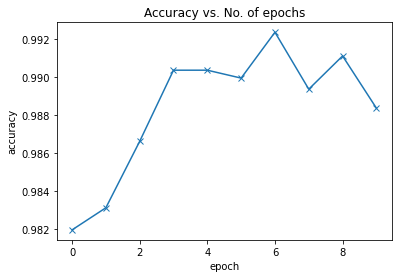

In [8]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

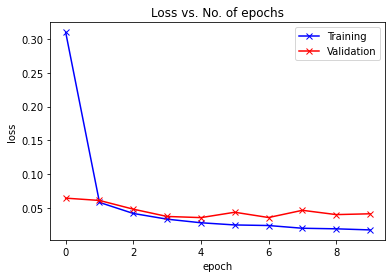

In [9]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

Shape of y_pred_all: (10000,)
Data type of y_pred_all: int64


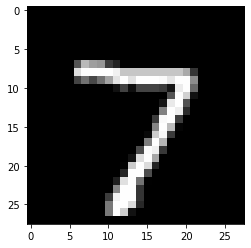

The predicted number is 7
The ground truth number is 7
Shape of y_true_all: (10000,)
Data type of y_true_all: int64


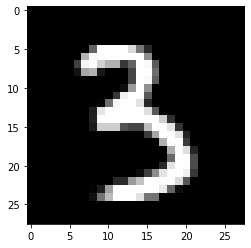

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [10]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Get predicted class probabilities
    probs = F.softmax(yb, dim=1)
    # Get predicted class index with highest probability
    _, preds = torch.max(probs, dim=1)
    # Convert to one-hot encoding
    y_pred = torch.zeros(10)
    y_pred[preds[0]] = 1
    return y_pred.numpy()

# Get the predicted labels for all data samples
def find_y_pred(test_data):
    y_pred_all = []
    for img, label in test_data:
        # Predict the label for the current image
        preds = predict_image(img, model)
        # Find the index of the maximum element in the prediction
        max_index = np.argmax(preds).astype(int)
        # Append the predicted label to the y_pred_all list
        y_pred_all.append(max_index)

    # Convert the list to a numpy array
    y_pred_all = np.array(y_pred_all)

    # Print the shape and data type of the array
    print("Shape of y_pred_all:", y_pred_all.shape)
    print("Data type of y_pred_all:", y_pred_all.dtype)
    return y_pred_all
y_pred_all=find_y_pred(test_data)

# Test the model for loading the test image
img, label = test_data[0]
image_array = img.numpy()
plt.imshow(np.squeeze(image_array), cmap='gray')
plt.show()

#prediction
preds=predict_image(img, model)
preds=preds.astype(int)

# Find the index of the maximum element
max_index = np.argmax(preds).astype(int)
print(f"The predicted number is {max_index}")
print(f"The ground truth number is {label}")

# Create one-hot encoded numpy array
y_true = np.zeros(10).astype(int)
y_true[label] = 1

# Get the true labels for all data samples
def find_y_true(test_data):
    y_true_all = []
    for img, label in test_data:
        y_true_all.append(label)

    # Convert the list to a numpy array
    y_true_all = np.array(y_true_all)

    # Print the shape and data type of the array
    print("Shape of y_true_all:", y_true_all.shape)
    print("Data type of y_true_all:", y_true_all.dtype)
    return y_true_all
#Call the function
y_true_all=find_y_true(test_data)

#Load another image for testing
img, label = test_data[32]
image_array = img.numpy()
plt.imshow(np.squeeze(image_array), cmap='gray')
plt.show()

preds=predict_image(img, model)
#Print one hot encoded vector
print(preds)

In [11]:
! pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[[ 966    0    0    0    0    4    8    1    1    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    6 1023    0    1    0    0    2    0    0]
 [   0    0    1  999    0    5    0    1    4    0]
 [   0    0    0    0  975    0    0    0    1    6]
 [   0    1    0    2    0  886    3    0    0    0]
 [   3    3    0    0    1    2  949    0    0    0]
 [   0    3    3    0    1    0    0 1021    0    0]
 [   2    0    2    1    0    1    3    0  963    2]
 [   0    0    0    0    5    8    0    3    1  992]]


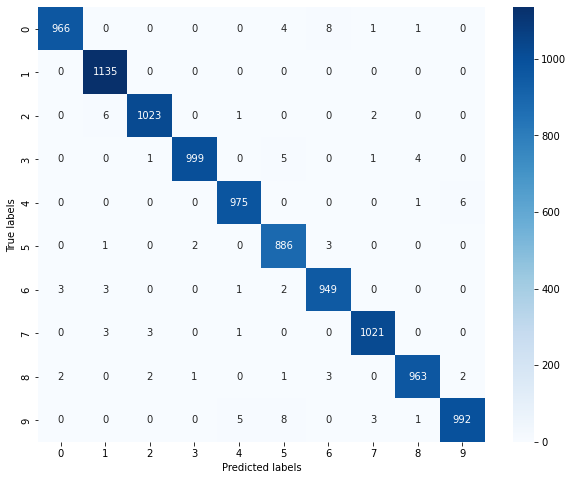

In [12]:
import numpy as np
#Defie the function for confusion matrix
def confusion_matrix(y_true, y_pred):

    # Get the number of unique labels in y_true
    num_classes = len(np.unique(y_true))

    # Create an empty confusion matrix
    matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Fill in the matrix by counting the occurrences of each class pair
    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]
        matrix[true_label][pred_label] += 1

    return matrix
cm=confusion_matrix(y_true_all,y_pred_all)
#Print the confusion matrix
print(cm)

#Applying visual effects to plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

 10%|█████████████████▌                                                                                                                                                             | 1/10 [00:49<07:26, 49.60s/it]

Epoch [0], train_loss: 0.2718, val_loss: 0.0910, val_acc: 0.9747


 20%|███████████████████████████████████                                                                                                                                            | 2/10 [01:39<06:40, 50.04s/it]

Epoch [1], train_loss: 0.0607, val_loss: 0.0505, val_acc: 0.9854


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 3/10 [02:25<05:35, 47.94s/it]

Epoch [2], train_loss: 0.0434, val_loss: 0.0576, val_acc: 0.9845


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 4/10 [03:14<04:51, 48.52s/it]

Epoch [3], train_loss: 0.0356, val_loss: 0.0384, val_acc: 0.9899


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [04:03<04:03, 48.60s/it]

Epoch [4], train_loss: 0.0275, val_loss: 0.0418, val_acc: 0.9896


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 6/10 [04:49<03:10, 47.56s/it]

Epoch [5], train_loss: 0.0230, val_loss: 0.0378, val_acc: 0.9900


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 7/10 [05:36<02:22, 47.50s/it]

Epoch [6], train_loss: 0.0216, val_loss: 0.0423, val_acc: 0.9889


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 8/10 [06:24<01:35, 47.58s/it]

Epoch [7], train_loss: 0.0215, val_loss: 0.0449, val_acc: 0.9887


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9/10 [07:13<00:48, 48.11s/it]

Epoch [8], train_loss: 0.0155, val_loss: 0.0523, val_acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:00<00:00, 48.00s/it]

Epoch [9], train_loss: 0.0161, val_loss: 0.0487, val_acc: 0.9909


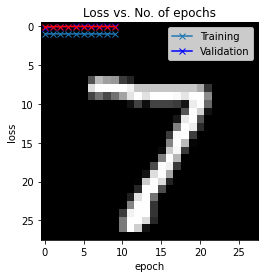

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Shape of y_pred_all: (10000,)
Data type of y_pred_all: int64


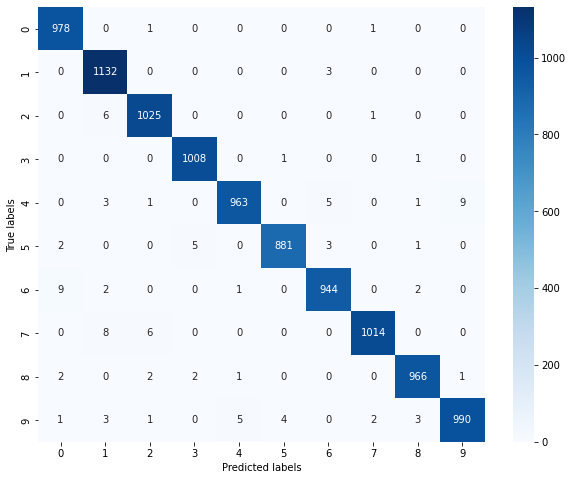

In [13]:
import torch.nn as nn
import torchvision.models as models

#Define the seperate class for resnet18
class Custom10ResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        #Important----> We are not using the pretrained model
        self.network = models.resnet18(pretrained=False)
        # Replace the last fully connected layer with 10 output classes
        self.network.fc = nn.Linear(512, 10)

    def forward(self, xb):
        return self.network(xb)

#Create instance of class
model = Custom10ResNet18()

#Trainloader and validation loader
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

#Give model to GPU
model = to_device(Custom10CnnModel(), device)

evaluate(model, val_dl)

#Define hyperparameters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

#load the test image and its label
img, label = test_data[0]
image_array = img.numpy()
plt.imshow(np.squeeze(image_array), cmap='gray')
plt.show()
#prediction
preds=predict_image(img, model)
#print one hot encoded vector
print(preds)

y_pred_all=find_y_pred(test_data)

#call confusion matrix function
cm=confusion_matrix(y_true_all,y_pred_all)
cm

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()



In [14]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, device="cuda", input_shape=(64, 1, 28, 28), dtype='fp32', nwarmup=50, nruns=100):
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [15]:
#CPU benchmarks
benchmark(model, device="cpu")

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 14.28 ms
Iteration 20/100, ave batch time 14.38 ms
Iteration 30/100, ave batch time 14.34 ms
Iteration 40/100, ave batch time 14.43 ms
Iteration 50/100, ave batch time 14.43 ms
Iteration 60/100, ave batch time 14.44 ms
Iteration 70/100, ave batch time 14.37 ms
Iteration 80/100, ave batch time 14.37 ms
Iteration 90/100, ave batch time 14.34 ms
Iteration 100/100, ave batch time 14.37 ms
Input shape: torch.Size([64, 1, 28, 28])
Output features size: torch.Size([64, 10])
Average batch time: 14.37 ms
